# Notebook for Global Weather Analysis

# Data Sampling and Collection

**Q: How were the data collected?**

A: The dataset on daily global weather for year 2020 is collected from the National Centers for Environmental Information (NCEI)'s Global Historical Climatorlogy Network (GHCN) Daily database, which contains daily climate reports from land surface stations across the globe. This dataset has records from over 100,000 stations in 180 countries over the years. The GHCN database receives daily updates from a variety of data streams, which also undergo a suite of quality checks.

**Q: Was there any potential bias introduced in the sampling process?**

A: The GHCN Daily database receives daily updates from its list of "subscribers", i.e., it receives data from registered stations across the globe. Hence, there may exist selection bias, because stations that do not work with the NCEI will not submit their data to the GHCN database, and so causing the GHCN database to miss such information. Even though GHCN is constantly updating the list of stations it receives from, there could always exist stations that don't submit data to GHCN. 

Other than that, the dataset has 8,514,264 entries, but appears to not have daily entries for each station. The number of entries by station varies from 1 to 296, out of 365.25 days in the year. As a result, some countries are represented better than others. Out of the 4970 stations we are using data from, the US has 1070 stations, Canada has 890 stations, and Russia has 609 stations. This means that over half of the data is generated from stations in just three countries. There are also only stations in 180 countries, while there are 195 countries in the world. This means that there are 15 countries which are not represented at all by the dataset. There are 40 countries which only have 1 station, and 56 countries which have 2 or less monitoring stations. This overrepresentation of some countries relative to others could be a source of bias.

# Data Cleaning

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import sys
!{sys.executable} -m pip install reverse_geocoder

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import reverse_geocoder as rg
pd.set_option('mode.chained_assignment', None)

Processing /home/jovyan/.cache/pip/wheels/10/05/be/d2edd4ff207cf625ce8bd20cf1493c27838828e8920aff9f4e/reverse_geocoder-1.5.1-py3-none-any.whl


In [2]:
daily_global_weather = pd.read_csv('daily_global_weather_2020.csv')
daily_global_weather.head()

,Unnamed: 0,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
0,0,AE000041196,2020-01-01,211.0,25.333,55.5170,34.0,0.0
1,1,AEM00041194,2020-01-01,217.0,25.255,55.3640,10.4,0.0
2,2,AFM00040938,2020-01-01,54.0,34.210,62.2280,977.2,23.0
3,3,AG000060611,2020-01-01,71.0,28.050,9.6331,561.0,10.0
4,4,AGE00147708,2020-01-01,99.0,36.720,4.0500,222.0,0.0


_Drop the redundant column Unnamed: 0_

In [3]:
print(daily_global_weather["Unnamed: 0"].unique() == daily_global_weather.index.to_list())
daily_global_weather_new = daily_global_weather.drop(columns=["Unnamed: 0"])
daily_global_weather_new.head()

[ True  True  True ...  True  True  True]


,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
0,AE000041196,2020-01-01,211.0,25.333,55.5170,34.0,0.0
1,AEM00041194,2020-01-01,217.0,25.255,55.3640,10.4,0.0
2,AFM00040938,2020-01-01,54.0,34.210,62.2280,977.2,23.0
3,AG000060611,2020-01-01,71.0,28.050,9.6331,561.0,10.0
4,AGE00147708,2020-01-01,99.0,36.720,4.0500,222.0,0.0


_Now we narrow down to entries of station reports in US, because we plan to conduct research questions primarily in US region with the use of several datasets._

In [4]:
daily_global_weather_US = daily_global_weather_new[daily_global_weather_new["Station"].str[0:2] == "US"]
daily_global_weather_US.head()

,Station,Date,TAVG,Latitude,Longitude,Elevation,PRCP
2542,USS0003E03S,2020-01-01,-8.0,44.11,-103.98,2100.1,51.0
2543,USS0003E05S,2020-01-01,15.0,44.21,-103.79,1868.4,25.0
2544,USS0004E07S,2020-01-01,14.0,44.49,-104.41,1801.4,51.0
2545,USS0005G04S,2020-01-01,-49.0,42.44,-105.86,2552.7,25.0
2546,USS0005G05S,2020-01-01,-42.0,42.28,-105.58,2407.9,0.0


**Q: What type of data are you exploring?**

A: In this dataset, we are exploring numerical data.

"Station" is a qualitative nominal variable that represents a station in the US that reports weather info.
"Date" encodes time-series information on when the weather info is reported. We may convert this column to datetime objects.
"TAVG" is a quantitative continuous variable that encodes the average temperature in tenths of C.
"Lattitude" and "Longtitude" are qualitative nominal variables that encode geographical location of the station.
"Elevation" is a quantitative continuous variable that encodes the height of station with respect to sea level.
"RPCP" is a quantitative continuous variable that encodes the average precipitation in tenths of MM.

**Q: What is the granularity of the data?**

A: Each row represents a weather report (the average temperature and precipitation) at a given station in US at a given date between 2020-01-01 to 2020-10-22. (This granularity is attained from the below analysis).

In [5]:
# TAVG is recorded as average temperature in tenths od degrees in C, so in order to properly retrieve the temperature in C, we divide by 10
daily_global_weather_US.loc[:, "TEMP_C"] = daily_global_weather_US.loc[:, "TAVG"] / 10.0
print("Temp in C:")
print(daily_global_weather_US["TEMP_C"].describe())
print()

# Date captures the date of the measurement
daily_global_weather_US["Datetime"] = pd.to_datetime(daily_global_weather_US["Date"], format="%Y-%m-%d")
print("Date in datetime format:")
print(daily_global_weather_US["Datetime"].describe())
print()

# Lattitude and Longitude captures the geographical location of a given station
print("Latitude:")
print(daily_global_weather_US["Latitude"].describe())
print()
print("Longitude:")
print(daily_global_weather_US["Longitude"].describe())
print()

# Elevation captures the height above the sea-level of the given measurement station
print("Elevation:")
print(daily_global_weather_US["Elevation"].describe())
print()

# PRCP captures the average precipitation in tenths of millimeters, in order to properly retrieve the precipitation in millimeters, we divide by 10
daily_global_weather_US.loc[:, "PRCP_Millimeter"] = daily_global_weather_US.loc[:, "PRCP"] / 10.0
print("PRCP_Millimeter:")
print(daily_global_weather_US["PRCP_Millimeter"].describe())
print()

Temp in C:
count    304466.000000
mean          8.378097
std          10.113867
min         -48.300000
25%           1.200000
50%           8.900000
75%          15.400000
max          40.800000
Name: TEMP_C, dtype: float64

Date in datetime format:
count                  304466
unique                    296
top       2020-04-25 00:00:00
freq                     1047
first     2020-01-01 00:00:00
last      2020-10-22 00:00:00
Name: Datetime, dtype: object

Latitude:
count    304466.000000
mean         42.805657
std           7.064853
min          19.719200
25%          38.990000
50%          42.360600
75%          45.500000
max          71.283300
Name: Latitude, dtype: float64

Longitude:
count    304466.000000
mean       -111.235003
std          16.121753
min        -170.222200
25%        -118.690000
50%        -111.490000
75%        -106.160000
max         -68.017200
Name: Longitude, dtype: float64

Elevation:
count    304466.000000
mean       1665.902292
std        1063.634190
min  

In [6]:
daily_global_weather_US_final = daily_global_weather_US[["Station", "Latitude", "Longitude",
                                                  "Elevation", "TEMP_C", "Datetime",
                                                  "PRCP_Millimeter"]]
daily_global_weather_US_final.head()

,Station,Latitude,Longitude,Elevation,TEMP_C,Datetime,PRCP_Millimeter
2542,USS0003E03S,44.11,-103.98,2100.1,-0.8,2020-01-01,5.1
2543,USS0003E05S,44.21,-103.79,1868.4,1.5,2020-01-01,2.5
2544,USS0004E07S,44.49,-104.41,1801.4,1.4,2020-01-01,5.1
2545,USS0005G04S,42.44,-105.86,2552.7,-4.9,2020-01-01,2.5
2546,USS0005G05S,42.28,-105.58,2407.9,-4.2,2020-01-01,0.0


In [7]:
def visualize_uni_distribution(df, name, ax, trans=None):
    if trans is None:
        sns.distplot(df[name], ax=ax)
    elif trans == "log":
        eps = 1e-10
        sns.distplot(np.log10(df[name] + eps), ax=ax)

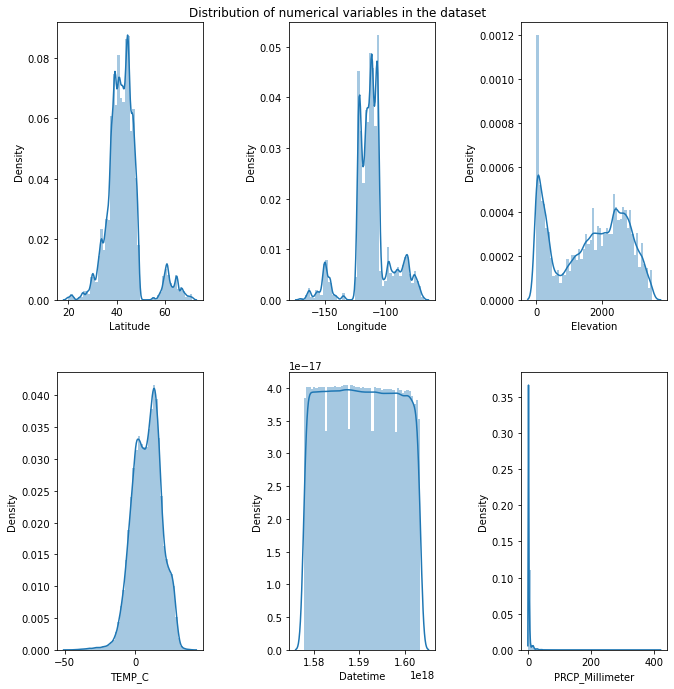

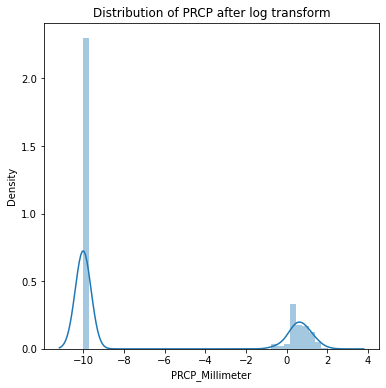

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(10,10))
i, j = 0, 0

for var in daily_global_weather_US_final.columns.to_list():
    if var == "Station":
        continue
    visualize_uni_distribution(daily_global_weather_US, var, axs[i, j])
    if j == 2:
        i += 1
        j = 0
    else:
        j += 1

fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of numerical variables in the dataset");

fig_1, ax_1 = plt.subplots(1, 1, figsize=(6,6))
visualize_uni_distribution(daily_global_weather_US, "PRCP_Millimeter", ax_1, trans="log")
ax_1.set_title("Distribution of PRCP after log transform");

**Q: What does the distribution of the data looks like?**

Latitude: This data is bimodal. The majority of latitude exists between about 30 and 50. Longitude: This data is multimodal. The majority of longitude exists between around -125 and -100. Latitude and longitude can be used to determine what are the popular places for these stations, i.e., what are the states or geographical locations that have a lot of such stations.

Elevation: This data is bimodal. The majority of elevation exists between about 0-500 and 2000-3000. It seems that the information of elevation will not be used later, so we can ignore it.

TEMP_C: This data is bimodal. The majority of temperature exists between -10 and 30, and we can see that the data has tiny percentage of values to both ends, and the curve is a little bit left skewed, but we can still fit a normal distribution to it. This suggests that the temperature data is pretty good, as the majority of them is near the mean and we don't have too many extreme values.

Datetime: This data is pretty uniform, with 4 troughs between 2020-01-01 and 2020-10-22. The visulization suggests that we have good coverage of data across Jan 2020 to Oct 2020. We may further inspect the date of the four troughs. Could these four days be the days where the database gets maintainance?

PRCP_Millimeter: This data is unimodal, and it is heavily right skewed (It has a long tail to the right). However, from above analysis, we can't say the measurement is an outlier, because the maximum 419.1 is still reasonable in nature for precipitation. To better visulize this distribution, we apply a log transformation, as shown below. After log transformation, we see the data is bimodal. This suggests that we have two clusters of pricipitation in the dataset, one around $0$, the other around $-10$.



In [9]:
print(daily_global_weather_US_final.isnull().sum())

Station            0
Latitude           0
Longitude          0
Elevation          0
TEMP_C             0
Datetime           0
PRCP_Millimeter    0
dtype: int64


**Q: Are there missing value or invalid entries in the dataset?**

A: By the above analysis, this dataset does not contain any missing value or invalid entries.

**Q: Are there any outliers?**

A: Based on our research on extreme weather data, including extremely high/low temperature and precipitation, its range seems valid and there is no outliers in the columns.

# Exploratory Data Analysis

In [10]:
daily_global_weather_US_final["year"] = daily_global_weather_US_final["Datetime"].dt.year
daily_global_weather_US_final["month"] = daily_global_weather_US_final["Datetime"].dt.month
daily_global_weather_US_final["week"] = daily_global_weather_US_final["Datetime"].dt.week
daily_global_weather_US_final["day"] = daily_global_weather_US_final["Datetime"].dt.day
daily_global_weather_US_final.head()

,Station,Latitude,Longitude,Elevation,TEMP_C,Datetime,PRCP_Millimeter,year,month,week,day
2542,USS0003E03S,44.11,-103.98,2100.1,-0.8,2020-01-01,5.1,2020,1,1,1
2543,USS0003E05S,44.21,-103.79,1868.4,1.5,2020-01-01,2.5,2020,1,1,1
2544,USS0004E07S,44.49,-104.41,1801.4,1.4,2020-01-01,5.1,2020,1,1,1
2545,USS0005G04S,42.44,-105.86,2552.7,-4.9,2020-01-01,2.5,2020,1,1,1
2546,USS0005G05S,42.28,-105.58,2407.9,-4.2,2020-01-01,0.0,2020,1,1,1


In [11]:
geo_cord = []
geo_cord = list(daily_global_weather_US_final[['Latitude', 'Longitude']].itertuples(index=False, name=None))
# use rg to search and make reverse of geo cord to county
res = rg.search(geo_cord)

states, county = [], []
for i in res:
    states.append(i["admin1"])
    county.append(i["admin2"])

daily_global_weather_US_final["state"] = states
daily_global_weather_US_final["county"] = county
daily_global_weather_US_final

Loading formatted geocoded file...


,Station,Latitude,Longitude,Elevation,TEMP_C,Datetime,PRCP_Millimeter,year,month,week,day,state,county
2542,USS0003E03S,44.1100,-103.9800,2100.1,-0.8,2020-01-01,5.1,2020,1,1,1,South Dakota,Lawrence County
2543,USS0003E05S,44.2100,-103.7900,1868.4,1.5,2020-01-01,2.5,2020,1,1,1,South Dakota,Lawrence County
2544,USS0004E07S,44.4900,-104.4100,1801.4,1.4,2020-01-01,5.1,2020,1,1,1,Wyoming,Crook County
2545,USS0005G04S,42.4400,-105.8600,2552.7,-4.9,2020-01-01,2.5,2020,1,1,1,Wyoming,Converse County
2546,USS0005G05S,42.2800,-105.5800,2407.9,-4.2,2020-01-01,0.0,2020,1,1,1,Wyoming,Converse County
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064278,USW00094847,42.2314,-83.3308,192.3,9.6,2020-10-22,15.7,2020,10,43,22,Michigan,Wayne County
1064279,USW00094849,45.0717,-83.5644,208.5,6.7,2020-10-22,9.9,2020,10,43,22,Michigan,Alpena County
1064280,USW00094860,42.8939,-85.5447,237.1,7.7,2020-10-22,16.5,2020,10,43,22,Michigan,Kent County
1064281,USW00094908,42.3978,-90.7036,321.9,7.3,2020-10-22,36.1,2020,10,43,22,Iowa,Dubuque County


In [12]:
daily_global_weather_US_final[daily_global_weather_US_final["county"] == 'San Francisco']

,Station,Latitude,Longitude,Elevation,TEMP_C,Datetime,PRCP_Millimeter,year,month,week,day,state,county


## Correlation 1: Is there a relationship between temperature and precipitation across the months?

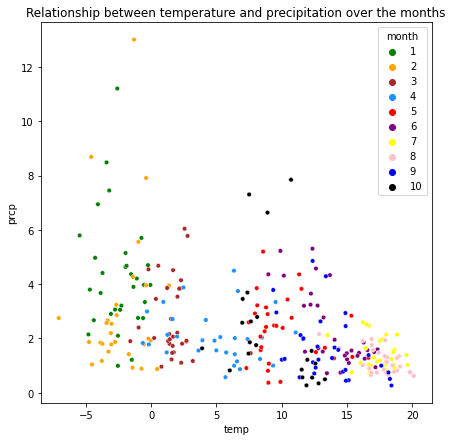

In [20]:
# construct a dataframe to contain the daily temperature and precipitation (avg across all stations that have data on that date)
corre_1 = pd.DataFrame()
corre_1["prcp"] = daily_global_weather_US_final.groupby(["month", "day"])["PRCP_Millimeter"].agg(np.mean)
corre_1["temp"] = daily_global_weather_US_final.groupby(["month", "day"])["TEMP_C"].agg(np.mean)
corre_1["month"] = daily_global_weather_US_final.groupby(["month", "day"])["month"].first()
corre_1.reset_index(drop=True, inplace=True)

# visualize
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.scatterplot(data=corre_1, 
                x="temp", 
                y="prcp", 
                hue="month",
                s=20,
                palette=['green','orange','brown','dodgerblue','red', 'purple', 'yellow', 'pink', 'blue', 'black'],
                ax=ax);
ax.set_title("Relationship between temperature and precipitation over the months");


**Visualization Analysis:**

From the above scatter plot, we can see that there is a relationship between temperature and precipitation. Using the daily averaged temperature and precipitation through Jan 2020 to Oct 2020, we can see that as the temperature increases, the amount of precipitation tends to decrease. In Jan and Feb, when the temperature is cold, we tend to see larger precipitation more often, while near summer, we tend to see the least precipitation (during July and august, we have the hottest days and we are less likely to see rains, and this is represented by the yellow and pink dots to the very right of the above graph). So, from this discovery, we can use temperature to infer the range of precipitation in the US region. Moreover, if you bin the above scatter plot by temperature, we can see different distribution of precipitation (in spring it is spread apart in the vertical axis, and in July and August it is more clustered near 1 in the vertical axis).

## Correlation 2: Is there a relationship between temperature/precipitation and specific month?

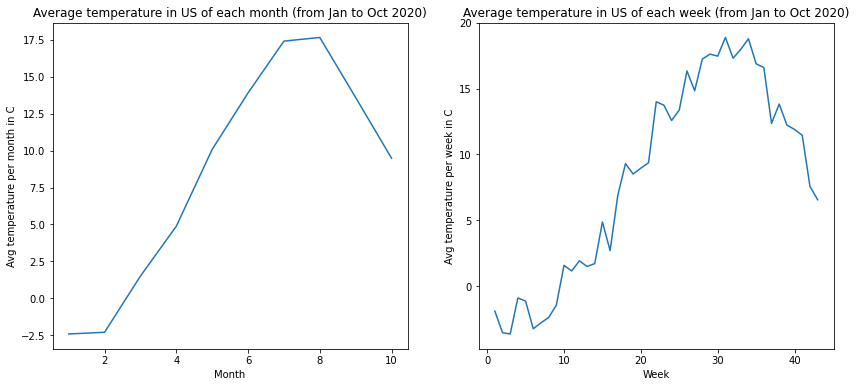

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# plot the monthly average temperature from Jan to Oct 2020 
month_temp_avg = daily_global_weather_US_final.groupby(["month"])["TEMP_C"].agg(np.mean)
axs[0].plot(month_temp_avg);
axs[0].set_title("Average temperature in US of each month (from Jan to Oct 2020)");
axs[0].set_xlabel("Month");
axs[0].set_ylabel("Avg temperature per month in C");

# plot the weeekly average temperature from Jan to Oct 2020 
week_temp_avg = daily_global_weather_US_final.groupby(["week"])["TEMP_C"].agg(np.mean)
axs[1].plot(week_temp_avg);
axs[1].set_title("Average temperature in US of each week (from Jan to Oct 2020)");
axs[1].set_xlabel("Week");
axs[1].set_ylabel("Avg temperature per week in C");

**Visualization Analysis:**

From the plot to the left, we can confidently say that there is a correlation between month and average temperature for that month. The graph shows that, as we transition from spring to summer, the temperature gradually increases, and stablizes for a month during the hottest month (July & Aug), and then starts to decline as we enter the fall season. Note that the dataset ends in Oct 2020, so we cannot visulize the winter season here. However, based on the above graph, we can see there is a correlation between the month and the average temperature. Based on how season transitions, we can infer temperature when we are given what month it is.

From the plot to the right, if we plot the weekly temperature, again we can see that we transition from a general trend to a more "oscilation" curve that still follows the monthly shape. This is expected, because in nature, temperature fluctuates up and down, while the transition of seasons ensure the general trend. This gives us an idea of the level of granularity to be used for the data to be fed into the model.

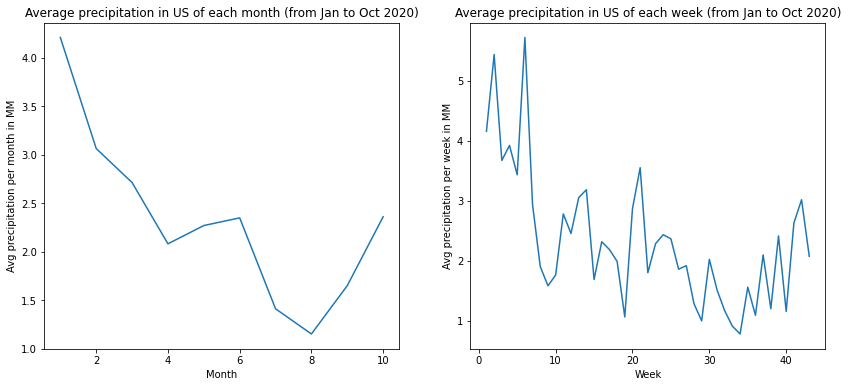

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# plot the monthly average precipitation from Jan to Oct 2020 
month_prcp_avg = daily_global_weather_US_final.groupby(["month"])["PRCP_Millimeter"].agg(np.mean)
axs[0].plot(month_prcp_avg);
axs[0].set_title("Average precipitation in US of each month (from Jan to Oct 2020)");
axs[0].set_xlabel("Month");
axs[0].set_ylabel("Avg precipitation per month in MM");

# plot the weekly average precipitation from Jan to Oct 2020 
week_prcp_avg = daily_global_weather_US_final.groupby(["week"])["PRCP_Millimeter"].agg(np.mean)
axs[1].plot(week_prcp_avg);
axs[1].set_title("Average precipitation in US of each week (from Jan to Oct 2020)");
axs[1].set_xlabel("Week");

axs[1].set_ylabel("Avg precipitation per week in MM");

**Visualization Analysis:**

From the plot to the left, we see that the spring in 2020 on average has more precipitation than other seasons. This is backed by scientific explanation, when during spring, the best precipitation dynamics of winter and summer converge. Correspondingly, we expect to see the least rain near august, as that is often the hottest time over the year (with a lot of droughts). For winter, we expect to see less rain as compared to spring. However, because the dataset ends in Oct, we cannot fully validate this trend. However, based on the above graph, we can see there is a correlation between the month and the average precipitation of that month.

From the plot to the right, if we plot the weekly precipitation, we can see that we transition from a general trend to a more "oscilation" curve. This is expected, because in nature, we know many phenomonons oscillate with respect to time. This gives us an idea of the level of granularity to be used for the data to be fed into the model.

**Q: Is there any correlation between the variables you are interested in exploring?**

From the above analysis, we can see that:

There is a relationship between precipitation and temperature across the months. It is less likely to rain during continuous hot weather, and so we expect to see less precipitation in summer, in the US region.
There is a relationship between the month and the average precipitation for that month. This is due to how season transitions and certain months are favorable for rains. There is also a relationship between the month and the average temperature for that month. This again is due to how season transitions.
From the above discoveries, we could summarize and say that, by collecting the month and precipitation, we can build a model to predict the temperature, as both precipitation and month have relationships with temperature.

**Q: How would you cleanly and accurately visualize the relationship among variables?**

Several techniques are used to cleanly and accurately visualize the relationship.

Given that we care about the average temperature and precipitation across the month, we use averaging to allow the data to generalize and be more smooth. Then, to observe clean and clear trend, we properly select graphing method and use proper color, and display size. We also use subplots to compare plots of different granularity on a certain topic.

